In [43]:
!export CUDA_VISIBLE_DEVICES='0'

In [ ]:
import os
import re
import pandas as pd

# Get the current working directory
cwd = os.getcwd()

# List all files in the current directory
files = os.listdir(cwd)

# Filter the list of files to only include CSV files
csv_files = [file for file in files if file.endswith('.csv') and file.startswith('epoch')]

# Define a function to extract the epoch and idx from a file name
def extract_epoch_idx(file):
    # Use a regular expression to match the epoch and idx in the file name
    try:
        # Extract the epoch and idx from the match object
        epoch = int(file.split('_')[1])
        idx = int(file.split('_')[3].split('.')[0])
        
        # Return the epoch and idx as a tuple
        print(file, epoch, idx)
    except:
        epoch = 0
        idx = 0
    return (epoch, idx)

# Sort the list of CSV files by epoch and then by idx
csv_files.sort(key=extract_epoch_idx)
print(csv_files)
# Read the first CSV file and store it in a DataFrame
df = pd.read_csv(csv_files[0])

# Loop through the remaining CSV files and merge them with the first DataFrame
for file in csv_files[1:]:
    # Read the current CSV file
    temp_df = pd.read_csv(file)
    
    # Merge the current DataFrame with the first DataFrame
    df = pd.concat([df, temp_df], axis=1)

# Save the resulting DataFrame to a new CSV file
df.to_csv('combined.csv', index=False)


Total images:  115846
Total classes:  1000
Distribution of classes:  Counter({86: 1280, 674: 1246, 566: 1173, 333: 1121, 417: 1053, 97: 819, 755: 787, 775: 775, 984: 714, 601: 683, 402: 679, 490: 652, 870: 642, 976: 625, 519: 619, 318: 611, 117: 604, 304: 566, 929: 534, 2: 516, 454: 511, 548: 507, 89: 502, 219: 496, 694: 481, 444: 480, 737: 472, 951: 472, 173: 469, 875: 459, 882: 456, 725: 454, 329: 446, 72: 428, 545: 422, 933: 418, 613: 413, 413: 411, 924: 398, 112: 393, 18: 392, 746: 392, 371: 391, 554: 382, 560: 381, 50: 376, 603: 376, 398: 372, 131: 370, 182: 367, 616: 354, 3: 352, 68: 349, 372: 349, 46: 346, 485: 346, 830: 343, 571: 340, 460: 333, 327: 332, 296: 330, 532: 330, 805: 328, 920: 323, 594: 317, 763: 315, 278: 310, 559: 310, 624: 310, 309: 306, 192: 305, 597: 305, 270: 303, 806: 302, 743: 299, 608: 298, 67: 297, 713: 297, 665: 296, 593: 292, 319: 290, 765: 290, 480: 288, 30: 287, 134: 285, 834: 285, 922: 284, 947: 284, 340: 283, 711: 283, 257: 282, 85: 281, 235: 281, 28

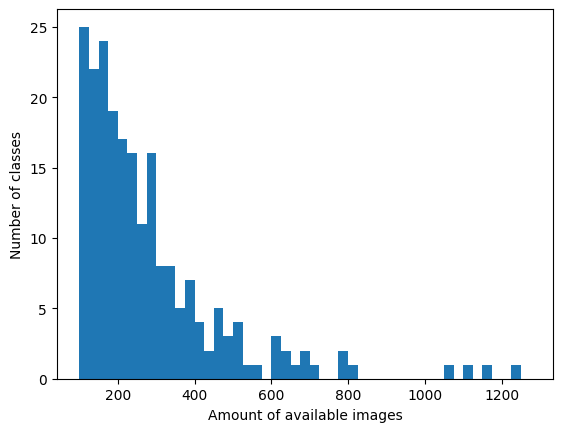

In [42]:
# file = ../../data/imagenet/ImageNet_LT_train.txt
# this file contains image name and label space separated
# print the distribution of labels
from collections import Counter


def print_distribution(file):
    with open(file) as f:
        labels = [int(line.split()[1]) for line in f]
    print("Total images: ", len(labels))
    print("Total classes: ", len(set(labels)))
    print("Distribution of classes: ", Counter(labels))

print_distribution("../../data/imagenet/ImageNet_LT_train.txt")
# visualize the distribution of labels
import matplotlib.pyplot as plt
def visualize_distribution(file):
    with open(file) as f:
        labels = [int(line.split()[1]) for line in f]
    class_numimages=Counter(labels)
    # count the classes with same number of images
    numimages_numclasses=Counter(class_numimages.values())
    plt.hist(numimages_numclasses, bins=range(100,max(numimages_numclasses),25))    
    plt.xlabel("Amount of available images")
    plt.ylabel("Number of classes")
visualize_distribution("../../data/imagenet/ImageNet_LT_train.txt")
# https://datascience.stackexchange.com/questions/11777/what-is-the-distribution-of-categories-in-imagenet-training-set-ilsvrc2012


In [67]:
# pass the dataset through the model and plot tsne
# import tsne
from argparse import Namespace

import torch
from dataset.datasets import set_loader
from sklearn import manifold
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from solvers.model import set_model

opt = Namespace()
opt.dataset = 'c2'
opt.data_folder = '../../data'
opt.loss = 'ce'
opt.imratio = 0.1
opt.batch_size = 128
opt.num_workers = 32
opt.cls_type = 'binary'
opt.model='resnet18'
opt.n_cls=2
def run_tsne():
    train_loader, test_loader = set_loader(opt)
    model, criterion= set_model(opt)
    model.eval()
    # get x and y
    X_train = []
    Y_train = []
    for idx, (images, labels)  in enumerate(train_loader):
        if labels.dim() == 2:
            labels = labels.squeeze(1) 
            # Assert: Shape of labels is reduced to single dimension

        labels=labels.long()
        images = images.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)
        
        features = model(images)
        features = torch.squeeze(features)
        X_train.append(features.cpu().detach().numpy().tolist())
        Y_train.append(labels.cpu().detach().numpy().tolist())
    # print("X_train shape: ", X_train.shape)
    # print("Y_train shape: ", Y_train.shape)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    print(X_train)
    print(Y_train)
    tsne = manifold.TSNE(n_components=2,
                         init='pca',
                         random_state=101,
                         method='barnes_hut',
                         n_iter=500,
                         verbose=2)
    train_tsne = tsne.fit_transform(X_train)
    return (train_tsne, Y_train)
train_tsne, Y_train = run_tsne()


Files already downloaded and verified
Files already downloaded and verified
#SAMPLES: [11128], POS:NEG: [1112 : 10016], POS RATIO: 0.0999
#SAMPLES: [5000], POS:NEG: [2516 : 2484], POS RATIO: 0.5032
[[[0.03256092220544815, -0.2513086199760437], [0.04118195176124573, -0.3139948844909668], [0.04158538207411766, -0.20731207728385925], [0.020547419786453247, -0.1226259395480156], [0.11925051361322403, -0.18023601174354553], [0.11036396771669388, -0.20749592781066895], [0.07938189804553986, -0.3223540186882019], [0.08730120956897736, -0.3441922962665558], [0.047720666974782944, -0.21498093008995056], [-0.0025096535682678223, -0.29520487785339355], [0.029623914510011673, -0.21789363026618958], [0.0018811775371432304, -0.1722886711359024], [0.03300471231341362, -0.24279040098190308], [0.10082639753818512, -0.4629817306995392], [0.12418600171804428, -0.4960556626319885], [0.0295172818005085, -0.14737601578235626], [0.046568796038627625, -0.29009395837783813], [-0.027815699577331543, -0.21544420

/home/anirudha/miniconda3/envs/cod/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (87,) + inhomogeneous part.

In [17]:

from __future__ import print_function

import os
import sys
import argparse
import time
import math
import matplotlib.pyplot as plt

import tensorboard_logger as tb_logger
import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets

from utils.util import TwoCropTransform, AverageMeter
# from util import adjust_learning_rate, warmup_learning_rate
# from util import set_optimizer, save_model
# from networks.main import SupConResNet
# from losses import SupConLoss
from dataset.datasets import set_loader


In [18]:
class opt:
    def __init__(self,dataset="cifar100",data_folder='../../data/',loss='supcon'):
        self.dataset=dataset
        self.data_folder=data_folder
        self.loss=loss
        self.size=32
        self.imratio=0.01
        self.batch_size=128
        self.num_workers=16
opt1=opt()
train_loader, val_loader=set_loader(opt1)


Files already downloaded and verified
Files already downloaded and verified
#SAMPLES: [25252], POS:NEG: [252 : 25000], POS RATIO: 0.0100
#SAMPLES: [10000], POS:NEG: [5000 : 5000], POS RATIO: 0.5000


In [26]:
class NoiseTransform:
    """Create two crops of the same image"""
    def __init__(self, transform, delta=1.0):
        self.transform = transform
        self.delta=delta

    def __call__(self, x):
        return self.transform(x)+self.delta*torch.rand_like(x)



In [27]:
# construct data loader
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
normalize = transforms.Normalize(mean=mean, std=std)
normalize=NoiseTransform(normalize,1)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomApply([
    #     transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    # ], p=0.8),
    # transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize,
])

train_dataset = datasets.CIFAR10(root="../datasets/",
                                        transform=train_transform,
                                        download=True)
train_sampler = None
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=(train_sampler is None),
    num_workers=16, pin_memory=True, sampler=train_sampler)
del train_dataset, train_sampler


Files already downloaded and verified


In [20]:
model=SupConResNet('resnet20')

NameError: name 'SupConResNet' is not defined

In [ ]:
print(len(images))

2


In [28]:
model=model.cuda()
model.train()
for idx, (images, labels) in enumerate(train_loader):
    # plot first 10 images
    images = torch.cat([images[0], images[1]], dim=0)
    if labels.dim() == 2:
        labels = labels.squeeze(1) # Assert: Shape of labels is reduced to single dimension
    labels=labels.long()
    # print(images)
    images = images.cuda(non_blocking=True)
    labels = labels.cuda(non_blocking=True)
    bsz = labels.shape[0]
    output = model(images)
    

    # if idx == 2:
    #     break
    # fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    # for i in range(5):
    #     ax = axes[0,i%5]
    #     ax = axes[0,i%5]
    #     img = images[0][i].squeeze().permute(1, 2, 0)
    #     label = labels[i]
    #     ax.imshow(img, interpolation='nearest')
    #     ax.set_title(label)
    #     ax.axis("off")

    #     ax = axes[1,i%5]
    #     img = images[1][i].squeeze().permute(1, 2, 0)
    #     label = labels[i]
    #     ax.imshow(img, interpolation='nearest')
    #     ax.set_title(label)
    #     ax.axis("off")
    # plt.show()



NameError: name 'model' is not defined

In [21]:
from torch.utils.data import Dataset
import numpy as np
class ImageDataset(Dataset):
    def __init__(self, images, targets,transform_train, image_size=32, crop_size=30, mode='train'):
        self.images = images.astype(np.uint8)
        self.targets = targets
        self.mode = mode
        self.transform_train = transform_train
        # self.transform_train = TwoCropTransform(transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.RandomCrop((crop_size, crop_size), padding=None),
        #     transforms.RandomHorizontalFlip(),
        #     transforms.Resize((image_size, image_size)),
        # ]))
        self.transform_test = TwoCropTransform(transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((image_size, image_size)),
        ]))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        target = self.targets[idx]
        image = Image.fromarray(image.astype('uint8'))
        if self.mode == 'train':
            image = self.transform_train(image)
        else:
            image = self.transform_test(image)
        return image, target


In [53]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)
normalize = transforms.Normalize(mean=mean, std=std)
normalize = NoiseTransform(normalize,10)
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    # transforms.RandomApply([
    #     transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
    # ], p=0.8),
    # transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize,
])
from libauc.datasets import CAT_VS_DOG, CIFAR10, CIFAR100
from PIL import Image
from torch.utils.data import Dataset
from libauc.utils import ImbalancedDataGenerator #BUG:  this is using import from conda install
SEED=123
imratio=0.5
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
train_data, train_targets = CIFAR10(root="../datasets/")

generator = ImbalancedDataGenerator(verbose=True, random_seed=SEED)
(train_images, train_labels) = generator.transform(
    train_data, train_targets, imratio=imratio)
    
train_sampler = None
train_loader2 = torch.utils.data.DataLoader(ImageDataset(
train_images, train_labels,TwoCropTransform(train_transform)), batch_size=256, shuffle=(train_sampler is None), num_workers=16, pin_memory=True, sampler=train_sampler)

# train_loader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=opt.batch_size, shuffle=(train_sampler is None),
#     num_workers=opt.num_workers, pin_memory=True, sampler=train_sampler)


Files already downloaded and verified
#SAMPLES: [50000], POS:NEG: [25000 : 25000], POS RATIO: 0.5000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

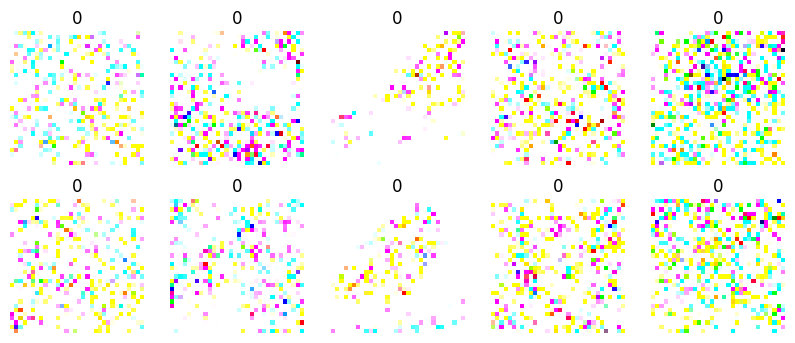

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

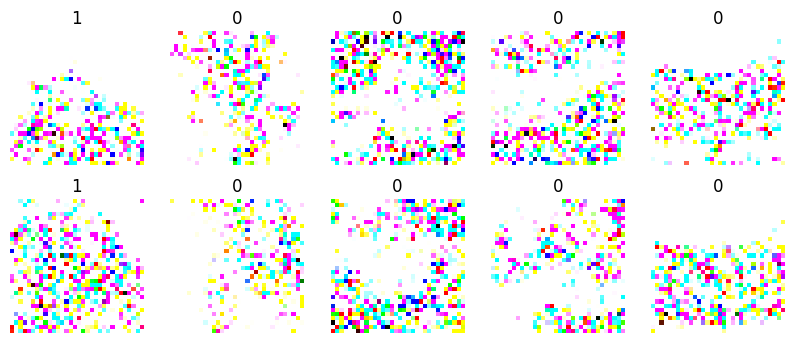

In [54]:
for idx, (images, labels) in enumerate(train_loader2):
    # plot first 10 images
    if idx == 2:
        break
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
    for i in range(5):
        ax = axes[0,i%5]
        ax = axes[0,i%5]
        img = images[0][i].squeeze().permute(1, 2, 0)
        label = labels[i].item()
        ax.imshow(img, interpolation='nearest')
        ax.set_title(label)
        ax.axis("off")

        ax = axes[1,i%5]
        img = images[1][i].squeeze().permute(1, 2, 0)
        label = labels[i].item()
        ax.imshow(img, interpolation='nearest')
        ax.set_title(label)
        ax.axis("off")
    plt.show()
# 0.3 0.6 1


In [2]:
from calibration_library.metrics import ECELoss

ECELoss()

In [1]:
from __future__ import print_function

import os
import sys
import argparse
import time
import math

import tensorboard_logger as tb_logger
import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets

from util import TwoCropTransform, AverageMeter
from util import adjust_learning_rate, warmup_learning_rate
from util import set_optimizer, save_model
from networks.resnet_big import SupConResNet
from losses import SupConLoss
from datasets import set_loader

try:
    import apex
    from apex import amp, optimizers
except ImportError:
    pass


def parse_option():
    parser = argparse.ArgumentParser('argument for training')

    parser.add_argument('--print_freq', type=int, default=10,
                        help='print frequency')
    parser.add_argument('--save_freq', type=int, default=200,
                        help='save frequency')
    parser.add_argument('--batch_size', type=int, default=256,
                        help='batch_size')
    parser.add_argument('--num_workers', type=int, default=16,
                        help='num of workers to use')
    parser.add_argument('--epochs', type=int, default=1000,
                        help='number of training epochs')

    # optimization
    parser.add_argument('--learning_rate', type=float, default=0.05,
                        help='learning rate')
    parser.add_argument('--lr_decay_epochs', type=str, default='700,800,900',
                        help='where to decay lr, can be a list')
    parser.add_argument('--lr_decay_rate', type=float, default=0.1,
                        help='decay rate for learning rate')
    parser.add_argument('--weight_decay', type=float, default=1e-4,
                        help='weight decay')
    parser.add_argument('--momentum', type=float, default=0.9,
                        help='momentum')

    # model dataset
    parser.add_argument('--model', type=str, default='resnet50')
    parser.add_argument('--dataset', type=str, default='cifar10',
                        choices=['cifar10', 'cifar100', 'c2','stl10','path'], help='dataset')
    parser.add_argument('--imratio', type=float, default=0.1,
                        help='imbalance ratio')
    parser.add_argument('--mean', type=str, help='mean of dataset in path in form of str tuple')
    parser.add_argument('--std', type=str, help='std of dataset in path in form of str tuple')
    parser.add_argument('--data_folder', type=str, default=None, help='path to custom dataset')
    parser.add_argument('--size', type=int, default=32, help='parameter for RandomResizedCrop')

    # method
    parser.add_argument('--method', type=str, default='SupCon',
                        choices=['SupCon', 'SimCLR'], help='choose method')

    # temperature
    parser.add_argument('--temp', type=float, default=0.07,
                        help='temperature for loss function')

    # other setting
    parser.add_argument('--cosine', action='store_true',
                        help='using cosine annealing')
    parser.add_argument('--syncBN', action='store_true',
                        help='using synchronized batch normalization')
    parser.add_argument('--warm', action='store_true',
                        help='warm-up for large batch training')
    parser.add_argument('--trial', type=str, default='0',
                        help='id for recording multiple runs')

    opt = parser.parse_args()

    # check if dataset is path that passed required arguments
    if opt.dataset == 'path':
        assert opt.data_folder is not None \
            and opt.mean is not None \
            and opt.std is not None

    # set the path according to the environment
    if opt.data_folder is None:
        opt.data_folder = '../../data/'
    opt.model_path = './save/SupCon/{}_models'.format(opt.dataset)
    opt.tb_path = './save/SupCon/{}_tensorboard'.format(opt.dataset)

    iterations = opt.lr_decay_epochs.split(',')
    opt.lr_decay_epochs = list([])
    for it in iterations:
        opt.lr_decay_epochs.append(int(it))

    opt.model_name = '{}_{}_{}_im_{}_lr_{}_decay_{}_bsz_{}_temp_{}_trial_{}'.\
        format(opt.method, opt.dataset, opt.model,opt.imratio, opt.learning_rate,
               opt.weight_decay, opt.batch_size, opt.temp, opt.trial)

    if opt.cosine:
        opt.model_name = '{}_cosine'.format(opt.model_name)

    # warm-up for large-batch training,
    if opt.batch_size > 256:
        opt.warm = True
    if opt.warm:
        opt.model_name = '{}_warm'.format(opt.model_name)
        opt.warmup_from = 0.01
        opt.warm_epochs = 10
        if opt.cosine:
            eta_min = opt.learning_rate * (opt.lr_decay_rate ** 3)
            opt.warmup_to = eta_min + (opt.learning_rate - eta_min) * (
                    1 + math.cos(math.pi * opt.warm_epochs / opt.epochs)) / 2
        else:
            opt.warmup_to = opt.learning_rate

    opt.tb_folder = os.path.join(opt.tb_path, opt.model_name)
    if not os.path.isdir(opt.tb_folder):
        os.makedirs(opt.tb_folder)

    opt.save_folder = os.path.join(opt.model_path, opt.model_name)
    if not os.path.isdir(opt.save_folder):
        os.makedirs(opt.save_folder)

    return opt


In [3]:
# opt=parse_option()
train_loader, val_loader= set_loader(opt)

NameError: name 'opt' is not defined

In [8]:
import numpy as np

# load npy file
datas=['balance', 'dermatology', 'ecoli', 'new-thyroid', 'pageblocks', 'segmentImb', 'shuttle', 'svmguide2', 'yeast']
for data_name in datas:
    # data_name='balance'
    base_path='data_multiclass/data_index/'+data_name+'.npz/'
    tot_X=base_path+'tot_X.npy'
    tot_Y=base_path+'tot_Y.npy'
    train_ids=base_path+'shuffle_train.npy'
    test_ids=base_path+'shuffle_test.npy'
    val_ids=base_path+'shuffle_val.npy'

    X = np.load(tot_X)
    Y = np.load(tot_Y)
    # print(data_name," X.shape:",X.shape," Y.shape:",Y.shape, "num_classes:",len(np.unique(Y)))
    print(len(np.unique(Y)),end=',')

3,6,8,3,5,7,5,3,10,

In [4]:
X

array([[1., 1., 1., 1.],
       [1., 1., 1., 4.],
       [1., 1., 1., 5.],
       ...,
       [4., 4., 3., 2.],
       [4., 4., 4., 4.],
       [5., 5., 5., 3.]])

In [8]:

import numpy as np
# generate random example of y_true of 100 classes
y_true = np.random.randint(0, 100, size=10000)
# y_pred should have 100 probabilities for each example corresponding to each class
# total probabilities for each example should sum to 1
y_pred = np.random.rand(10000, 100)
y_pred /= y_pred.sum(axis=1, keepdims=True)
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_true, y_pred, multi_class='ovo'))
from utils.metrics import auc_m
print(auc_m(y_true, y_pred))



0.501421923014798
[78 60 16 ... 43 10 18]
[[0.01510692 0.00607293 0.01183135 ... 0.01818145 0.0139016  0.01805855]
 [0.011214   0.01928716 0.01532953 ... 0.01574848 0.01773453 0.01281325]
 [0.00796855 0.00111742 0.004441   ... 0.00905945 0.01901078 0.01247125]
 ...
 [0.0081318  0.00093869 0.00959779 ... 0.00170727 0.01456077 0.0106784 ]
 [0.01082967 0.00538478 0.02137472 ... 0.00077902 0.00622439 0.01026592]
 [0.01614879 0.00126017 0.00646391 ... 0.00344391 0.01850783 0.00452765]]
10000
10000
(10000,)
(10000, 100)
0.501421923014798


In [9]:
y_true.shape
# y_pred.shape

(10000,)

In [22]:
import numpy as np
data_name='ecoli'
base_path='data_multiclass/data_index/'+data_name+'.npz/'
tot_X=base_path+'tot_X.npy'
tot_Y=base_path+'tot_Y.npy'
train_ids=base_path+'shuffle_train.npy'
test_ids=base_path+'shuffle_test.npy'
val_ids=base_path+'shuffle_val.npy'


In [30]:
np.load(tot_X).shape


(336, 7)

In [25]:
np.load(train_ids).shape

(15, 72)

In [26]:
np.load(tot_X)[np.load(train_ids)].shape

(15, 72, 7)

In [29]:
np.load(tot_Y).shape
# np.load(tot_Y)

(336, 1)

In [ ]:
import torch
output = np.random.randint(0, 100, size=10000)

output = torch.nn.functional.normalize(output, p=2, dim=1)


: 